# Credit Score Classification

## Members: Atul Gupta, Shubham Kulkarni, Nancy, Siddharth Prabhakaran

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.simplefilter("ignore")

In [2]:
# Importing the dataset

train_file = "/Users/atul/Library/CloudStorage/OneDrive-Personal/Stevens Institute of Technology/Courses/CS 513/Project/Datasets/Credit score classification/train.csv"
test_file = "/Users/atul/Library/CloudStorage/OneDrive-Personal/Stevens Institute of Technology/Courses/CS 513/Project/Datasets/Credit score classification/test.csv"

X = pd.read_csv(train_file)
y = pd.read_csv(test_file)

In [3]:
X.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [4]:
X.iloc[0]

ID                                                                     0x1602
Customer_ID                                                         CUS_0xd40
Month                                                                 January
Name                                                            Aaron Maashoh
Age                                                                        23
SSN                                                               821-00-0265
Occupation                                                          Scientist
Annual_Income                                                        19114.12
Monthly_Inhand_Salary                                             1824.843333
Num_Bank_Accounts                                                           3
Num_Credit_Card                                                             4
Interest_Rate                                                               3
Num_of_Loan                                                     

### Preprocessing and EDA

We have identified the following issues with the data:

1. Includes columns that are not useful. We have identified those columns to be:
    ID, Customer_ID, Month, Name, SSN, Occupation, Num_Bank_Accounts, Num_Credit_Card
2. Numerical columns contain certain non-numerical values like '54_' making the entire column non-numerical.
3. Not Applicable or Not Available values are represented by garbage values like '!@9#%8' in Payment_Behaviour column, 'NM' (Not Mentioned) in Payment_of_Min_Amount column, '_' in CreditMix column etc.
4. Certain numerical values way out of the expected range for example, age being 5000 or number of bank accounts being negative or interest rate being 3000.
5. 'Type_of_Loan' column has 9 unique comma-separated values that generate more than a thousand unique combinations in the dataset.
6. Time period in Credit_History_Age column is expressed as a string.
7. The data set is imbalanced.

These issues are addressed as follows:

1. Removed the columns that are not useful.
2. Converted the entire dataset to string and removed all underscores. Then converted each column to its original datatype.
3. Identified these garbage values and replaced them with np.nan and dropped them later.
4. Defined boundary values for such columns. If any value falls outside of these boundaries, they are replacd with None and then later dropped.
5. Created a unique One Hot Encoder that separates the unique values in 'Type_of_Loan' column into separate columns and uses binary classification to include/exclude these values for every row.
6. Converted the time period into months using regular expressions.
7. Oversampled the dataset to balance it (NEED TO IMPLEMENT)

In [5]:
min_age = 18
max_age = 100
max_num_credit_cards = 10
max_interest_rate = 50
max_num_loans = 10
max_num_credit_inquiries = 50

# Function to remove underscores from a string value
def remove_underscore(value):
    if isinstance(value, str):
        return value.replace('_', '')
    return value

# Function to check if a value falls between min_age and max_age
def check_valid_age(value):
    if value >= min_age and value <= max_age:
        return value
    return None

# Function to check if max number of credit cards fall between expected boundaries.
def check_num_credit_cards(value):
    if value <= max_num_credit_cards:
        return value
    return None

def check_interest_rate(value):
    if value <= max_interest_rate:
        return value
    return None

def check_max_num_loan(value):
    if value >= 0 and value <= max_num_loans:
        return value
    return None

def check_num_delayed_payments(value):
    if isinstance(value, int) and value >= 0:
        return value
    return None

def check_num_credit_inquiries(value):
    if value <= max_num_credit_inquiries:
        return value
    return None

def check_outstanding_debt(value):
    if value >= 0:
        return value
    return None

def check_credit_history_age(value):
    match = re.match(r'(\d+) Years and (\d+) Months', value)

    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        total_months = years * 12 + months
        return total_months
    return None

def divide_loan_column(X):
    loan_unique = X["Type_of_Loan"].unique()
    type_of_loan = []

    for item in loan_unique:
        item_list = item.split(',')
        for loan in item_list:
            loan = loan.replace(' ','')
            loan = loan.replace('and','')
            if loan not in type_of_loan:
                type_of_loan.append(loan)
            
    type_of_loan.remove('nan')

    X[type_of_loan] = 0

    for index, row in X.iterrows():
        item = row["Type_of_Loan"]
        item_list = item.split(',')
        try:
            item_list.remove('nan')
        except ValueError:
            pass
        for loan in item_list:
            loan = loan.replace(' ','')
            loan = loan.replace('and','')
            X.at[index,loan] = 1

    X.drop('Type_of_Loan',axis=1,inplace=True)
    return X

def preprocessing(data):

    data.drop_duplicates(inplace=True)
    
    integer_columns = ['Age','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date',
                      'Num_of_Delayed_Payment','Num_Credit_Inquiries']
    float_columns = ['Annual_Income','Monthly_Inhand_Salary','Changed_Credit_Limit','Outstanding_Debt','Credit_Utilization_Ratio',
                    'Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']
    
    data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].fillna(0)
    
    data = data.astype(str)
    data = data.applymap(remove_underscore)
    
    for column in integer_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('Int64')
    
    for column in float_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('float64')

    data['Age'] = data['Age'].apply(check_valid_age).astype('Int64')
    #data['Num_Credit_Card'] = data['Num_Credit_Card'].apply(check_num_credit_cards).astype('Int64')
    data['Interest_Rate'] = data['Interest_Rate'].apply(check_interest_rate).astype('Int64')
    data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].apply(check_num_delayed_payments).astype('Int64')
    data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].apply(check_num_credit_inquiries).astype('Int64') #FIX the boolean value issue
    data['Outstanding_Debt'] = data['Outstanding_Debt'].apply(check_outstanding_debt).astype('float64')
    data['Credit_History_Age'] = data['Credit_History_Age'].apply(check_credit_history_age).astype('Int64')
    return data

X = preprocessing(X)
y = preprocessing(y)

In [6]:
removable_features = ['ID','Customer_ID','Month','Name','SSN','Occupation','Num_Bank_Accounts','Num_Credit_Card']
X = X.drop(removable_features,axis=1)

In [7]:
X["Payment_Behaviour"].replace('!@9#%8',np.nan,inplace=True)
X["Payment_of_Min_Amount"].replace('NM',np.nan,inplace=True)
X["Credit_Mix"].replace('',np.nan,inplace=True)

X.dropna(inplace=True)

X = divide_loan_column(X)
y = divide_loan_column(y)

In [8]:
X.dtypes

Age                           Int64
Annual_Income               float64
Monthly_Inhand_Salary       float64
Interest_Rate                 Int64
Num_of_Loan                   Int64
Delay_from_due_date           Int64
Num_of_Delayed_Payment        Int64
Changed_Credit_Limit        float64
Num_Credit_Inquiries          Int64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age            Int64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
AutoLoan                      int64
Credit-BuilderLoan            int64
PersonalLoan                  int64
HomeEquityLoan                int64
NotSpecified                  int64
MortgageLoan                  int64
DebtConsolidationLoan         int64
PaydayLoan                    int64
StudentLoan                 

In [9]:
X.shape

(37806, 28)

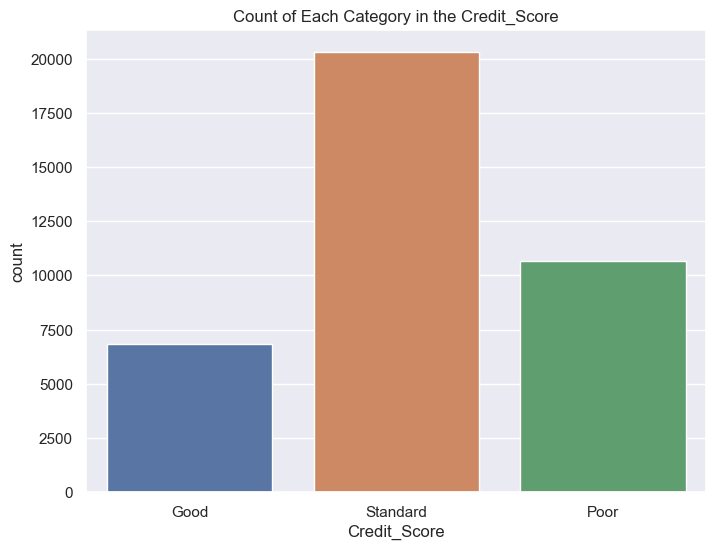

In [10]:
# Imbalanced dataset

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='Credit_Score', data=X)

plt.title('Count of Each Category in the Credit_Score')
plt.show()

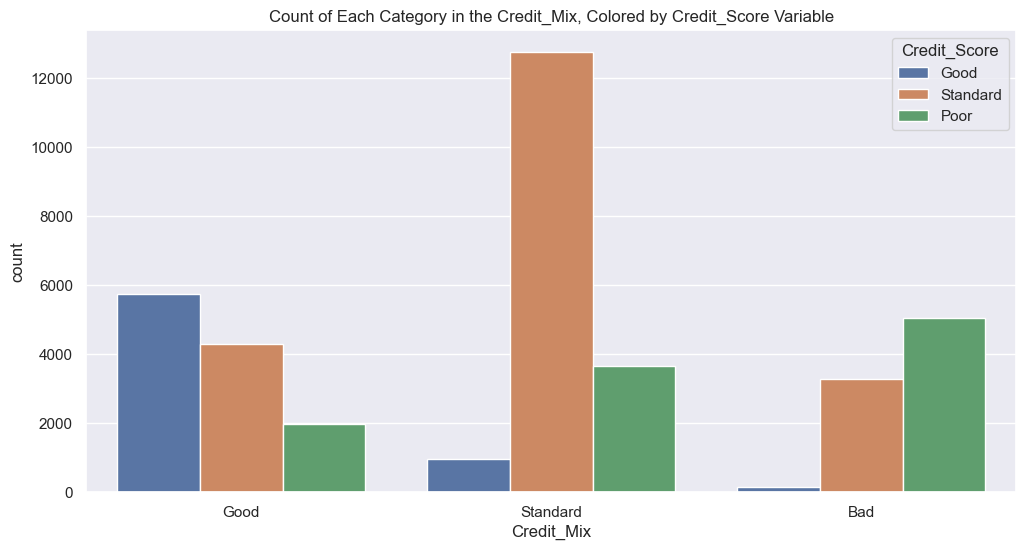

In [11]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.countplot(x='Credit_Mix', hue='Credit_Score', data=X)

plt.title('Count of Each Category in the Credit_Mix, Colored by Credit_Score Variable')
plt.show()

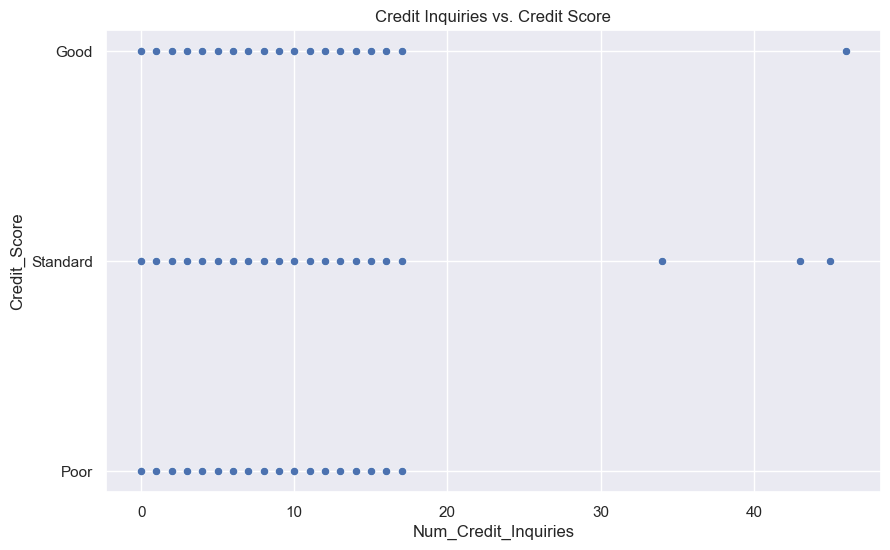

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Num_Credit_Inquiries', y='Credit_Score', data=X)

plt.title('Credit Inquiries vs. Credit Score')
plt.show()

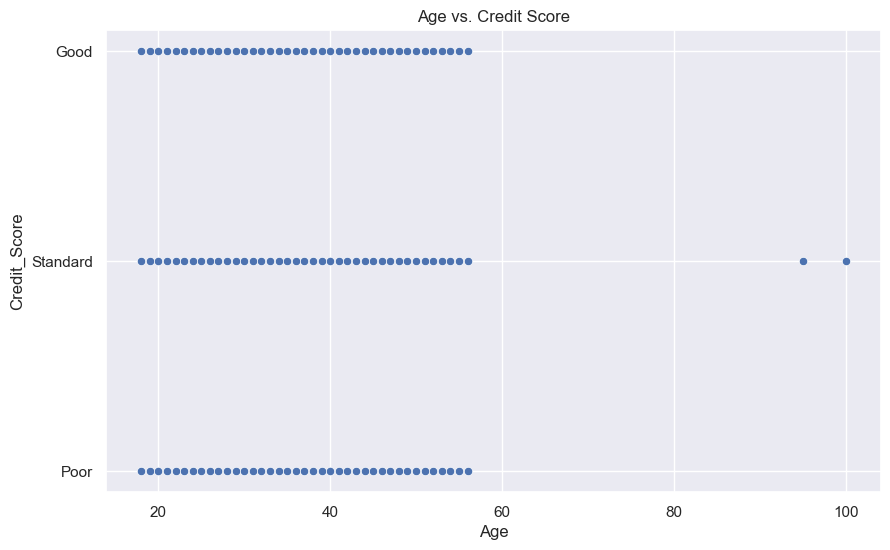

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Credit_Score', data=X)

plt.title('Age vs. Credit Score')
plt.show()

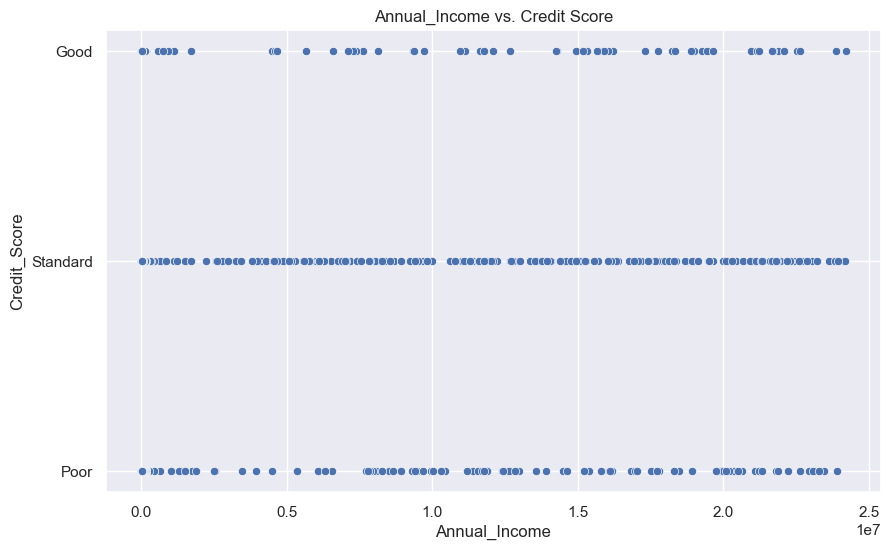

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual_Income', y='Credit_Score', data=X)

plt.title('Annual_Income vs. Credit Score')
plt.show()

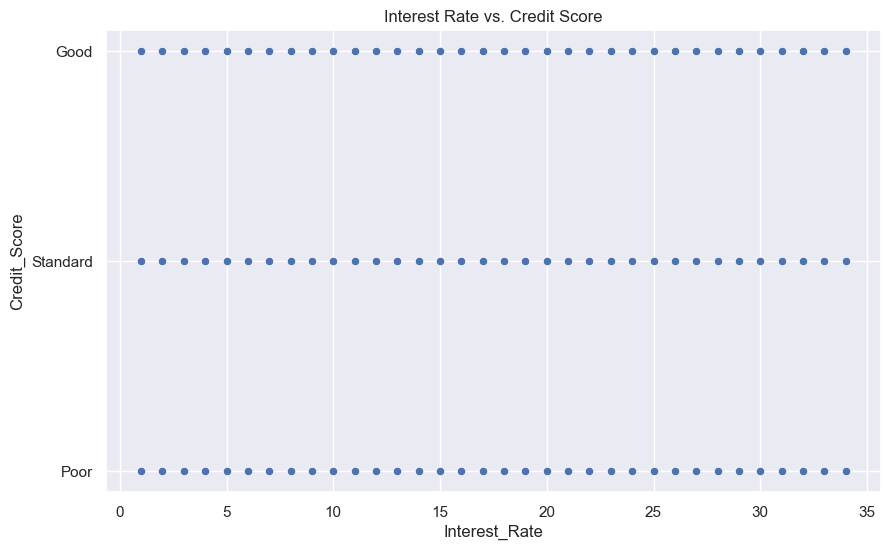

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Interest_Rate', y='Credit_Score', data=X)

plt.title('Interest Rate vs. Credit Score')
plt.show()

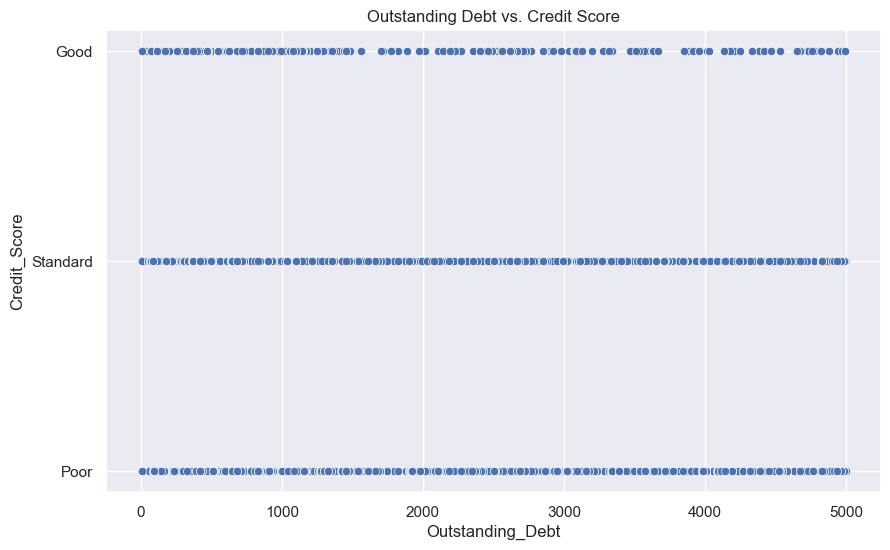

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Outstanding_Debt', y='Credit_Score', data=X)

plt.title('Outstanding Debt vs. Credit Score')
plt.show()

In [17]:
print(X["Payment_of_Min_Amount"].unique())
print(X["Payment_Behaviour"].unique())
print(X["Credit_Mix"].unique())
print(X["Credit_Score"].unique())

['No' 'Yes']
['LowspentSmallvaluepayments' 'HighspentLargevaluepayments'
 'HighspentSmallvaluepayments' 'LowspentLargevaluepayments'
 'HighspentMediumvaluepayments' 'LowspentMediumvaluepayments']
['Good' 'Standard' 'Bad']
['Good' 'Standard' 'Poor']


In [18]:
X.iloc[0]

Age                                                 23
Annual_Income                                 19114.12
Monthly_Inhand_Salary                      1824.843333
Interest_Rate                                        3
Num_of_Loan                                          4
Delay_from_due_date                                  3
Num_of_Delayed_Payment                               8
Changed_Credit_Limit                             11.27
Num_Credit_Inquiries                                 4
Credit_Mix                                        Good
Outstanding_Debt                                809.98
Credit_Utilization_Ratio                     22.537593
Credit_History_Age                                 271
Payment_of_Min_Amount                               No
Total_EMI_per_month                          49.574949
Amount_invested_monthly                     178.344067
Payment_Behaviour           LowspentSmallvaluepayments
Monthly_Balance                             244.565317
Credit_Sco

In [19]:
def normalize_data(data):
    data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].round(2)
    label_cols = ['Payment_of_Min_Amount','Credit_Mix']
    encoder_col = 'Payment_Behaviour'
    data_cols = ['Age','Interest_Rate','Num_of_Loan','Changed_Credit_Limit','Delay_from_due_date','Num_of_Delayed_Payment',
                 'Num_Credit_Inquiries','Annual_Income','Monthly_Inhand_Salary','Outstanding_Debt',
                 'Credit_Utilization_Ratio','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly',
                 'Monthly_Balance']
    
    for col in label_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    
    encoder = OneHotEncoder(sparse=False)
    data[encoder_col] = encoder.fit_transform(data[encoder_col].values.reshape(-1,1))

    scaler = MinMaxScaler()
    
    for column in data_cols:
        data[column] = scaler.fit_transform(data[column].values.reshape(-1,1))
    
    return data

X = normalize_data(X)
y = normalize_data(y)

le = LabelEncoder()
X["Credit_Score"] = le.fit_transform(X["Credit_Score"])
X.iloc[0]

Age                         0.060976
Annual_Income               0.000501
Monthly_Inhand_Salary       0.102087
Interest_Rate               0.060606
Num_of_Loan                 0.065615
Delay_from_due_date         0.111111
Num_of_Delayed_Payment      0.001819
Changed_Credit_Limit        0.414463
Num_Credit_Inquiries        0.086957
Credit_Mix                  1.000000
Outstanding_Debt            0.162020
Credit_Utilization_Ratio    0.056882
Credit_History_Age          0.669154
Payment_of_Min_Amount       0.000000
Total_EMI_per_month         0.000603
Amount_invested_monthly     0.017834
Payment_Behaviour           0.000000
Monthly_Balance             1.000000
Credit_Score                0.000000
AutoLoan                    1.000000
Credit-BuilderLoan          1.000000
PersonalLoan                1.000000
HomeEquityLoan              1.000000
NotSpecified                0.000000
MortgageLoan                0.000000
DebtConsolidationLoan       0.000000
PaydayLoan                  0.000000
S

In [20]:
# Correlation matrix
numerical_columns = X.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_columns.corr()
corr_matrix

,Age,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,...,Credit_Score,AutoLoan,Credit-BuilderLoan,PersonalLoan,HomeEquityLoan,NotSpecified,MortgageLoan,DebtConsolidationLoan,PaydayLoan,StudentLoan
Age,1.000000,0.006440,0.061679,-0.171813,-0.002617,-0.138101,-0.000306,-0.126548,-0.186146,0.068241,...,-0.038907,-0.065279,-0.057927,-0.082138,-0.054138,-0.077859,-0.055465,-0.079854,-0.071670,-0.060436
Annual_Income,0.006440,1.000000,0.031742,-0.017295,-0.003156,-0.011009,-0.002678,-0.007692,-0.015488,-0.002887,...,0.005547,0.005193,0.003614,-0.001384,0.002057,0.001787,-0.008300,-0.014194,-0.011587,-0.004099
Monthly_Inhand_Salary,0.061679,0.031742,1.000000,-0.298792,-0.010193,-0.244869,0.001425,-0.177195,-0.269921,0.095137,...,-0.071879,-0.092327,-0.118226,-0.097466,-0.102392,-0.098078,-0.093058,-0.108282,-0.098871,-0.097312
Interest_Rate,-0.171813,-0.017295,-0.298792,1.000000,0.024708,0.589828,0.014651,0.374299,0.611412,-0.304018,...,0.123507,0.221725,0.228521,0.212076,0.223755,0.212727,0.219380,0.207080,0.223831,0.210125
Num_of_Loan,-0.002617,-0.003156,-0.010193,0.024708,1.000000,0.017285,0.005220,0.017691,0.021592,-0.010706,...,0.003486,0.023842,0.013852,0.016119,0.018247,0.016382,0.013820,0.010760,0.015826,0.015557
Delay_from_due_date,-0.138101,-0.011009,-0.244869,0.589828,0.017285,1.000000,0.011426,0.304327,0.520633,-0.400973,...,0.098667,0.195077,0.194034,0.198588,0.197995,0.168980,0.190619,0.188048,0.197177,0.189387
Num_of_Delayed_Payment,-0.000306,-0.002678,0.001425,0.014651,0.005220,0.011426,1.000000,0.009693,0.003440,0.001852,...,0.005579,-0.004268,0.009638,0.001127,0.001871,0.000093,0.009271,0.001592,0.005609,0.001594
Changed_Credit_Limit,-0.126548,-0.007692,-0.177195,0.374299,0.017691,0.304327,0.009693,1.000000,0.370473,-0.078929,...,0.183636,0.150876,0.153606,0.140585,0.153225,0.132333,0.132857,0.136508,0.135734,0.146266
Num_Credit_Inquiries,-0.186146,-0.015488,-0.269921,0.611412,0.021592,0.520633,0.003440,0.370473,1.000000,-0.324273,...,0.059389,0.210275,0.220661,0.209591,0.205088,0.207861,0.211484,0.206048,0.227824,0.211421
Credit_Mix,0.068241,-0.002887,0.095137,-0.304018,-0.010706,-0.400973,0.001852,-0.078929,-0.324273,1.000000,...,0.237228,-0.151765,-0.164681,-0.160223,-0.167003,-0.147679,-0.167744,-0.138377,-0.164723,-0.166845


In [21]:
print("Top 5 Most Important Features:")
print(corr_matrix['Credit_Score'].abs().sort_values(ascending=False).head(5))

Top 6 Most Important Features:
Credit_Score             1.000000
Payment_of_Min_Amount    0.269200
Credit_Mix               0.237228
Changed_Credit_Limit     0.183636
Interest_Rate            0.123507
Delay_from_due_date      0.098667
Name: Credit_Score, dtype: float64


In [22]:
X.iloc[0]

Age                         0.060976
Annual_Income               0.000501
Monthly_Inhand_Salary       0.102087
Interest_Rate               0.060606
Num_of_Loan                 0.065615
Delay_from_due_date         0.111111
Num_of_Delayed_Payment      0.001819
Changed_Credit_Limit        0.414463
Num_Credit_Inquiries        0.086957
Credit_Mix                  1.000000
Outstanding_Debt            0.162020
Credit_Utilization_Ratio    0.056882
Credit_History_Age          0.669154
Payment_of_Min_Amount       0.000000
Total_EMI_per_month         0.000603
Amount_invested_monthly     0.017834
Payment_Behaviour           0.000000
Monthly_Balance             1.000000
Credit_Score                0.000000
AutoLoan                    1.000000
Credit-BuilderLoan          1.000000
PersonalLoan                1.000000
HomeEquityLoan              1.000000
NotSpecified                0.000000
MortgageLoan                0.000000
DebtConsolidationLoan       0.000000
PaydayLoan                  0.000000
S

In [23]:
X.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,...,Credit_Score,AutoLoan,Credit-BuilderLoan,PersonalLoan,HomeEquityLoan,NotSpecified,MortgageLoan,DebtConsolidationLoan,PaydayLoan,StudentLoan
6,0.060976,0.000501,0.102087,0.060606,0.065615,0.111111,0.001819,0.414463,0.086957,1,...,0,1,1,1,1,0,0,0,0,0
8,0.121951,0.001151,0.183501,0.151515,0.063722,0.111111,0.000910,0.277557,0.043478,1,...,2,0,1,0,0,0,0,0,0,0
9,0.121951,0.001151,0.183501,0.151515,0.063722,0.166667,0.000227,0.324362,0.043478,1,...,0,0,1,0,0,0,0,0,0,0
12,0.121951,0.001151,0.183501,0.151515,0.063722,0.111111,0.000227,0.300960,0.043478,1,...,0,0,1,0,0,0,0,0,0,0
13,0.121951,0.001151,0.183501,0.151515,0.063722,0.111111,0.000000,0.277557,0.043478,1,...,0,0,1,0,0,0,0,0,0,0


In [24]:
# Splitting the training dataset into test and train
feature_data = X.drop(['Credit_Score'],axis=1)
target = X['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(feature_data, target, test_size=0.3)

In [25]:
# Implementing Logistic Regression

lr_model = LogisticRegression(penalty='l2',random_state=42)

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.6301357785223065
[[1100   25  908]
 [ 245 1537 1406]
 [ 781  830 4510]]
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2033
           1       0.64      0.48      0.55      3188
           2       0.66      0.74      0.70      6121

    accuracy                           0.63     11342
   macro avg       0.61      0.59      0.59     11342
weighted avg       0.63      0.63      0.63     11342



In [26]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)

Accuracy: 0.77

Confusion Matrix:
 [[1442   18  573]
 [ 155 2374  659]
 [ 581  678 4862]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.68      2033
           1       0.77      0.74      0.76      3188
           2       0.80      0.79      0.80      6121

    accuracy                           0.77     11342
   macro avg       0.74      0.75      0.75     11342
weighted avg       0.77      0.77      0.77     11342



In [27]:
# Instantiate XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7386704284958561


In [28]:
svm_model = SVC(kernel='linear', random_state=42)

# Train the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)

Accuracy: 0.63

Confusion Matrix:
 [[1655   38  340]
 [ 537 1610 1041]
 [1258 1030 3833]]

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.81      0.60      2033
           1       0.60      0.51      0.55      3188
           2       0.74      0.63      0.68      6121

    accuracy                           0.63     11342
   macro avg       0.61      0.65      0.61     11342
weighted avg       0.65      0.63      0.63     11342

